In [56]:
import numpy as np
import pandas as pd
import mysql
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
from mysql.connector import connection
register_matplotlib_converters()
import math

In [2]:
connection = mysql.connector.connect(
        host= 'ec2-18-117-169-228.us-east-2.compute.amazonaws.com', #'127.0.0.1'
        port=  3310,
        database = 'database_fiumi',  #'rivers_db'
        user = 'root',
        password = 'password'
        )
connection.autocommit = True
cursor = connection.cursor()

In [3]:
query = 'SELECT Timestamp, W_mean from Try_Isarco' 
df = pd.read_sql(query, con=connection)
tempo = df['Timestamp']
print(df)

                Timestamp  W_mean
0     2019-02-28 00:00:00     NaN
1     2019-02-28 01:00:00     NaN
2     2019-02-28 02:00:00     NaN
3     2019-02-28 03:00:00     NaN
4     2019-02-28 04:00:00     NaN
...                   ...     ...
20150 2021-06-16 20:00:00  248.17
20151 2021-06-16 21:00:00  249.50
20152 2021-06-16 22:00:00  248.17
20153 2021-06-16 23:00:00  247.67
20154 2021-06-20 13:20:00  260.00

[20155 rows x 2 columns]


In [4]:
droppare = []
i = 0 
while i < (len(df['W_mean'])):
        if np.isnan(df['W_mean'][i]):
                droppare.append(i)
        i += 1

for j in droppare :
    df =  df.drop(j)

In [5]:
df = df.reset_index()
print(df)

       index           Timestamp  W_mean
0        162 2019-03-06 18:00:00  114.00
1        163 2019-03-06 19:00:00  114.67
2        164 2019-03-06 20:00:00  121.33
3        165 2019-03-06 21:00:00  133.83
4        166 2019-03-06 22:00:00  141.83
...      ...                 ...     ...
19988  20150 2021-06-16 20:00:00  248.17
19989  20151 2021-06-16 21:00:00  249.50
19990  20152 2021-06-16 22:00:00  248.17
19991  20153 2021-06-16 23:00:00  247.67
19992  20154 2021-06-20 13:20:00  260.00

[19993 rows x 3 columns]


In [6]:
df1 = df
df2 = df
df3 = df
df4 = df

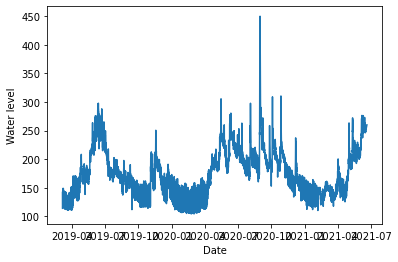

In [7]:
plt.xlabel('Date')
plt.ylabel('Water level')
plt.plot(df['Timestamp'],df['W_mean'])
plt.show()

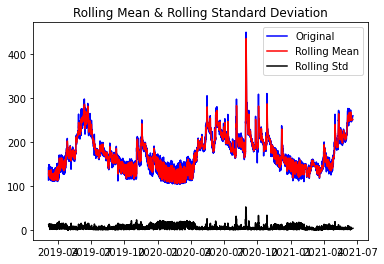

In [8]:
rolling_mean = df['W_mean'].rolling(window = 12).mean()
rolling_std = df['W_mean'].rolling(window = 12).std()
plt.plot(df['Timestamp'],df['W_mean'], color = 'blue', label = 'Original')
plt.plot(df['Timestamp'], rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(df['Timestamp'],rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

0        4.736198
1        4.742058
2        4.798514
3        4.896570
4        4.954629
           ...   
19988    5.514114
19989    5.519459
19990    5.514114
19991    5.512097
19992    5.560682
Name: W_mean, Length: 19993, dtype: float64


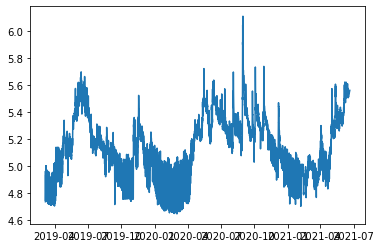

In [9]:
df_log = np.log(df['W_mean'])
print(df_log)
plt.plot(df['Timestamp'],df_log)

In [10]:
def get_stationarity(df,timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # rolling statistics plot
    original = plt.plot(df['Timestamp'],timeseries, color='blue', label='Original')
    mean = plt.plot(df['Timestamp'],rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(df['Timestamp'],rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
           ...   
19988   -0.020873
19989   -0.012681
19990   -0.014682
19991   -0.013562
19992    0.033948
Name: W_mean, Length: 19993, dtype: float64


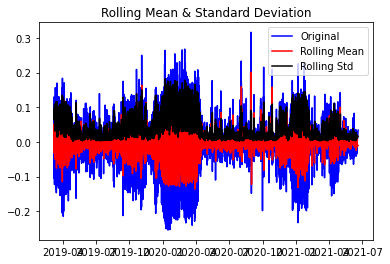

ADF Statistic: -20.942506987359774
p-value: 0.0
Critical Values:
	1%: -3.4306780568917654
	5%: -2.8616849895907084
	10%: -2.56684717400185


In [11]:
rolling_mean = df_log.rolling(window=12).mean()
df_log_minus_mean = df_log - rolling_mean
print((df_log_minus_mean))
for i in range(len(df_log_minus_mean)):
    if np.isnan(df_log_minus_mean[i]):
        df1 = df1.drop(i)
 
    
df_log_minus_mean.dropna(inplace=True)
get_stationarity(df1, df_log_minus_mean)

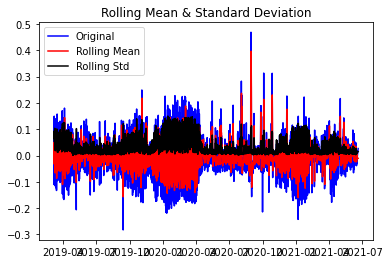

ADF Statistic: -17.089625050928205
p-value: 7.606720457137628e-30
Critical Values:
	1%: -3.4306778759577727
	5%: -2.8616849096286727
	10%: -2.5668471314394736


In [12]:
rolling_mean_exp_decay = df_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
df_log_exp_decay = df_log - rolling_mean_exp_decay
df_log_exp_decay.dropna(inplace=True)
get_stationarity(df2, df_log_exp_decay)



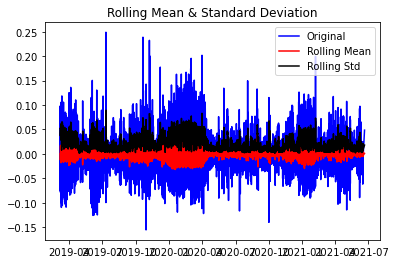

ADF Statistic: -26.06053555581722
p-value: 0.0
Critical Values:
	1%: -3.430677908840016
	5%: -2.861684924160664
	10%: -2.566847139174595


In [13]:
df_log_shift = df_log - df_log.shift()
for k in range(len(df_log_shift)):
    if np.isnan(df_log_shift[k]):
        df3 = df3.drop(k)
df_log_shift.dropna(inplace=True)
get_stationarity(df3, df_log_shift)

0        4.736198
1        4.742058
2        4.798514
3        4.896570
4        4.954629
           ...   
19988    5.514114
19989    5.519459
19990    5.514114
19991    5.512097
19992    5.560682
Name: W_mean, Length: 19993, dtype: float64


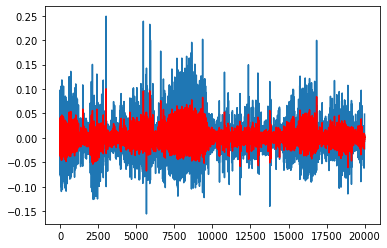

In [33]:
#df_log['W_mean'] = np.log(df['W_mean'])
print(df_log)
#print(df_log.dtypes)
'''i = 0 
while i < len(df_log):
    df_log['Timestamp'][i] = str(df_log['Timestamp'][i])
    i += 1 
'''

decomposition = seasonal_decompose(df_log, period = 1, model = 'additive')  
model = ARIMA(df_log, order=(2,1,2))
results = model.fit(disp=-1)
plt.plot(df_log_shift)
plt.plot(results.fittedvalues, color='red')
plt.show()

138.0793115786339


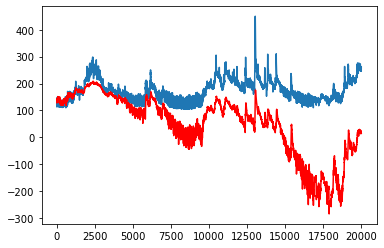

In [60]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df_log.iloc[0], index=df_log.index)
#print(predictions_ARIMA_log)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)

#####
differences = []
for i in range(len(predictions_ARIMA)):
    differences.append((df['W_mean'][i]-predictions_ARIMA[i])**2)
mean_dist = math.sqrt(sum(differences)/len(differences))
print(mean_dist)
new_axis = (df['W_mean'][0])
pred = []
for el in predictions_ARIMA:
    pred.append((el * -1) + new_axis + mean_dist)
######

plt.plot(df['W_mean'])
#plt.plot(predictions_ARIMA)
plt.plot(pred, color = 'red')
(plt.show())

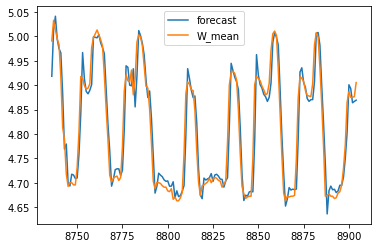

In [16]:
results.plot_predict(8736,8904)
plt.show()